# Group 28: Predicting Magnitude of Forest Fires

##### Group Members: Teanna Urquhart, Jade Bouchard, Brian Kong, Adam Chen 

## Introduction

Over the past few years, extreme forest fires have become a major environmental problem, raising global concern. Due to climate change creating hotter and drier conditions, the planet is more conductive than ever to fire proliferation. However, the complexity and extent of forest fires go further beyond the statistics, including human casualties, financial costs, and burnt land [1].  It is recognized as a "major threat to public health security in the 21st century [2]." From our forest fires data set, we want to **predict how much area will be burned in a forest fire by analyzing weather conditions known to affect fire occurrences**. 

The data consists of a collection of 517 records, each corresponding to a fire that occurred in the Montesinho natural park, in the northeast region of Portugal, from January 2000 to December 2003. The following list below contains the selected dataset predictors against our response variable, "area", which is measured in hectares.

**Dataset Attributes:**
- Month (Month of the year)
- FFMC (FFMC index from the FWI system) -> moisture content of surface litter (key to ignition and fire spread)
- DMC (DMC index from the FWI system) -> moisture content of shallow organic layers ((important to surface fire intensity and difficulty of control)
- DC (DC index from the FWI system) -> moisture content of deep organic layers (important to surface fire intensity and difficulty of control)
- ISI (ISI index from the FWI system) -> score that correlates with fire velocity spread
- Temp (temperature in Celsius degrees)
- RH (relative humidity in %)
- Wind (wind speed in km/h)
- Rain (outside rain mm/m2)


Given the necessary information about a location, we expect to be able to predict with reasonable accuracy the area burned if a forest fire were to occur in that location. We also expect to determine which predictor variables create a good statistical model.

One potential impact is that our model could help with fire evacuation. If a fire is predicted to cover a very large area, it could be life saving to alert citizens in that area of the danger and evacuate with ample time.

## Exploratory Data Analysis

First, we install the packages and read the libraries needed for this analysis, then we read the data from our url.

In [1]:
# Install packages 
install.packages('Metrics')
install.packages('leaps')

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



In [2]:
# Read in relevant libraries
library(tidyverse)
library(GGally)
library(Metrics)
library(leaps)
library(broom)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [3]:
#Set random seed to 123
set.seed(123)

#Read in the data 
forest_fire_data <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv")


First, let's take a peek at the distribution of our response variable, `area`.

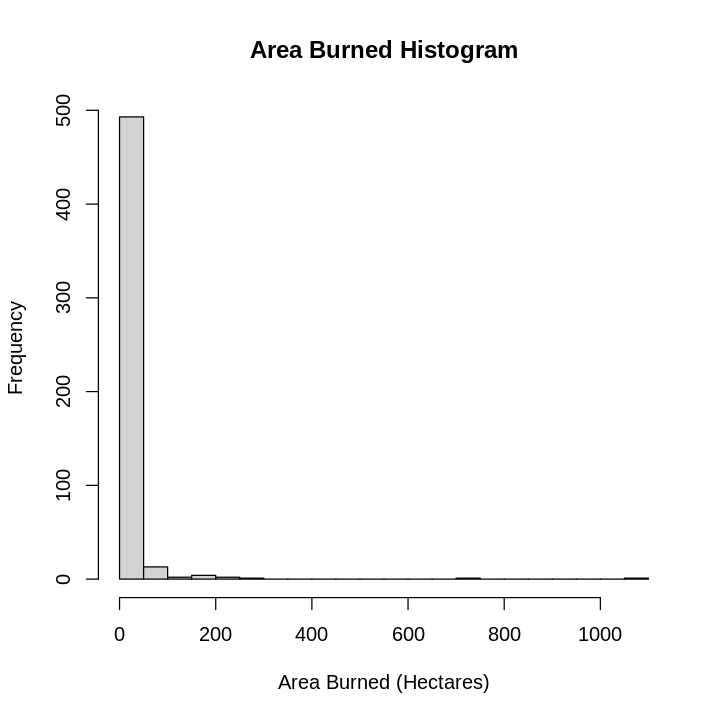

In [4]:
#Area burned histogram
options(repr.plot.width = 6, repr.plot.height = 6) 
hist(forest_fire_data$area, breaks = 20, main = "Area Burned Histogram", xlab = "Area Burned (Hectares)")

_**Figure 1: Histogram of Response Variable: Area Burned**_

Our response variable, `area`, is skewed towards 0. Therefore, we start off by making a natural log transformation on it. We do this in order to meet the assumption of linear regression that errors are normally distributed.

In [5]:
#Log transforming the response
forest_fire_data <- forest_fire_data %>%
mutate(log_area = log(area),) %>%
select(-area)%>%
filter(!log_area %in% -c(NA, NaN, Inf))

Now our histogram will be much less skewed, which indicates that our errors will be more normally distributed. This is important as normally distributed errors is one of the assumptions for linear regression.

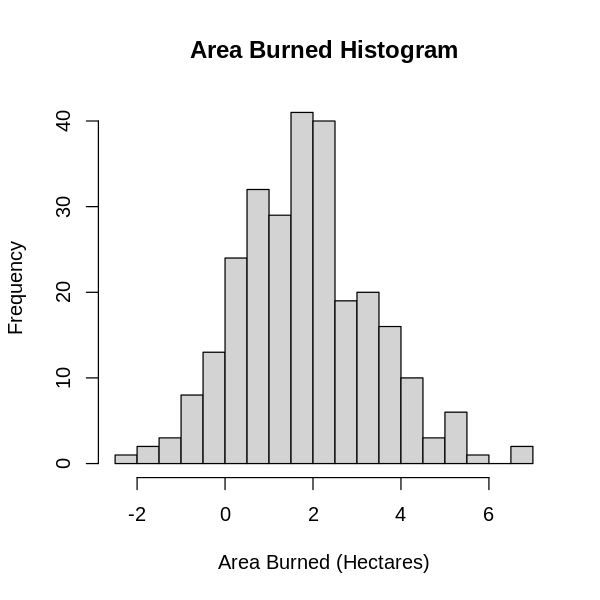

In [6]:
#Log Area Burned Histogram
options(repr.plot.width = 5, repr.plot.height = 5) 
hist(forest_fire_data$log_area, breaks = 20, main = "Area Burned Histogram", xlab = "Area Burned (Hectares)")

_**Figure 2: Histogram of Response Variable: Log Area Burned**_

Next, we split the data into testing (20%) and training (80%) datasets. 

In [7]:
#Split into training and testing datasets
dt = sort(sample(nrow(forest_fire_data), nrow(forest_fire_data)*.8))
forest_train_data<-forest_fire_data[dt,]
forest_test_data<-forest_fire_data[-dt,]

#Print beginning and end of training dataset
head(forest_train_data)
tail(forest_train_data)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area
,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0,-1.0216512
4,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0,-0.5978370
5,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0,-0.4942963
6,1,2,jul,sat,90.0,51.3,296.3,8.7,16.6,53,5.4,0,-0.3424903
7,2,5,aug,wed,95.5,99.9,513.3,13.2,23.8,32,5.4,0,-0.2613648
8,6,5,aug,thu,95.2,131.7,578.8,10.4,27.4,22,4.0,0,-0.1053605


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area
,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
264,4,3,aug,wed,94.5,139.4,689.1,20.0,28.9,29,4.9,0.0,3.9037892
265,1,2,aug,thu,91.0,163.2,744.4,10.1,26.7,35,1.8,0.0,1.7578579
266,5,4,aug,fri,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,0.7747272
267,6,5,aug,fri,91.0,166.9,752.6,7.1,18.2,62,5.4,0.0,-0.8439701
269,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,3.9943400
270,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,2.4123360


| _Table 1: Initial Training Forest Fire Data_ |
| ------------------------ |
||

From Table 1, we see that our training dataset has 12 potential explanatory variables, besides the target variable `log_area`. Two are categorical, while the other 10 are numeric. We will clean this data up to have easily understandable column names. 


In [8]:
# Make human friendly columns 
forest_train_data <- forest_train_data %>%
    rename(
    x_axis_coord = X,
    y_axis_coord = Y,
    relative_humidity = RH,
    log_area_burned = log_area)

forest_test_data <- forest_test_data %>%
    rename(
    x_axis_coord = X,
    y_axis_coord = Y,
    relative_humidity = RH,
    log_area_burned = log_area)

head(forest_train_data)

,x_axis_coord,y_axis_coord,month,day,FFMC,DMC,DC,ISI,temp,relative_humidity,wind,rain,log_area_burned
,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0,-1.0216512
4,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0,-0.5978370
5,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0,-0.4942963
6,1,2,jul,sat,90.0,51.3,296.3,8.7,16.6,53,5.4,0,-0.3424903
7,2,5,aug,wed,95.5,99.9,513.3,13.2,23.8,32,5.4,0,-0.2613648
8,6,5,aug,thu,95.2,131.7,578.8,10.4,27.4,22,4.0,0,-0.1053605


| _Table 2: Renamed Training Forest Fire Dataset_|
| ------------------------ |
||

To continue cleaning our data, we check whether any columns have missing data.

In [9]:
#Check for missing data
num_missing_cells <- sum(is.na(forest_fire_data))
num_missing_cells 

[1] 0

This shows that there are no missing cells in our initial dataset! To clean the data further, we can narrow down which explanatory variables to keep. The specific day of the week is not likely to have an impact on area burned, we believe any correlation found would be coincidental, so as such we will remove the column `day` from the training dataset. We recognize that our dataset is time series. However, since day is of no percieved relevance and month has a small enough number of unique values such that it can be treated as categorical, we will proceed with the rest of the report without treating our dataset as time series.

In [10]:
# Get rid of unimportant features in data: the day data
forest_train_clean_data <- select(forest_train_data, -day)
forest_test_clean_data <- select(forest_test_data, -day)
head(forest_train_clean_data)

,x_axis_coord,y_axis_coord,month,FFMC,DMC,DC,ISI,temp,relative_humidity,wind,rain,log_area_burned
,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,9,9,jul,85.8,48.3,313.4,3.9,18.0,42,2.7,0,-1.0216512
4,1,2,aug,95.5,99.9,513.3,13.2,23.3,31,4.5,0,-0.5978370
5,8,6,aug,90.1,108.0,529.8,12.5,21.2,51,8.9,0,-0.4942963
6,1,2,jul,90.0,51.3,296.3,8.7,16.6,53,5.4,0,-0.3424903
7,2,5,aug,95.5,99.9,513.3,13.2,23.8,32,5.4,0,-0.2613648
8,6,5,aug,95.2,131.7,578.8,10.4,27.4,22,4.0,0,-0.1053605


| _Table 3: Clean Training Forest Fire Dataset_|
| ------------------------ |
||

In order to explore the variables' relations with one another, we will use ggpairs to plot the pairs of scatterplots for all the numeric variables (month is not included as it is categorical).

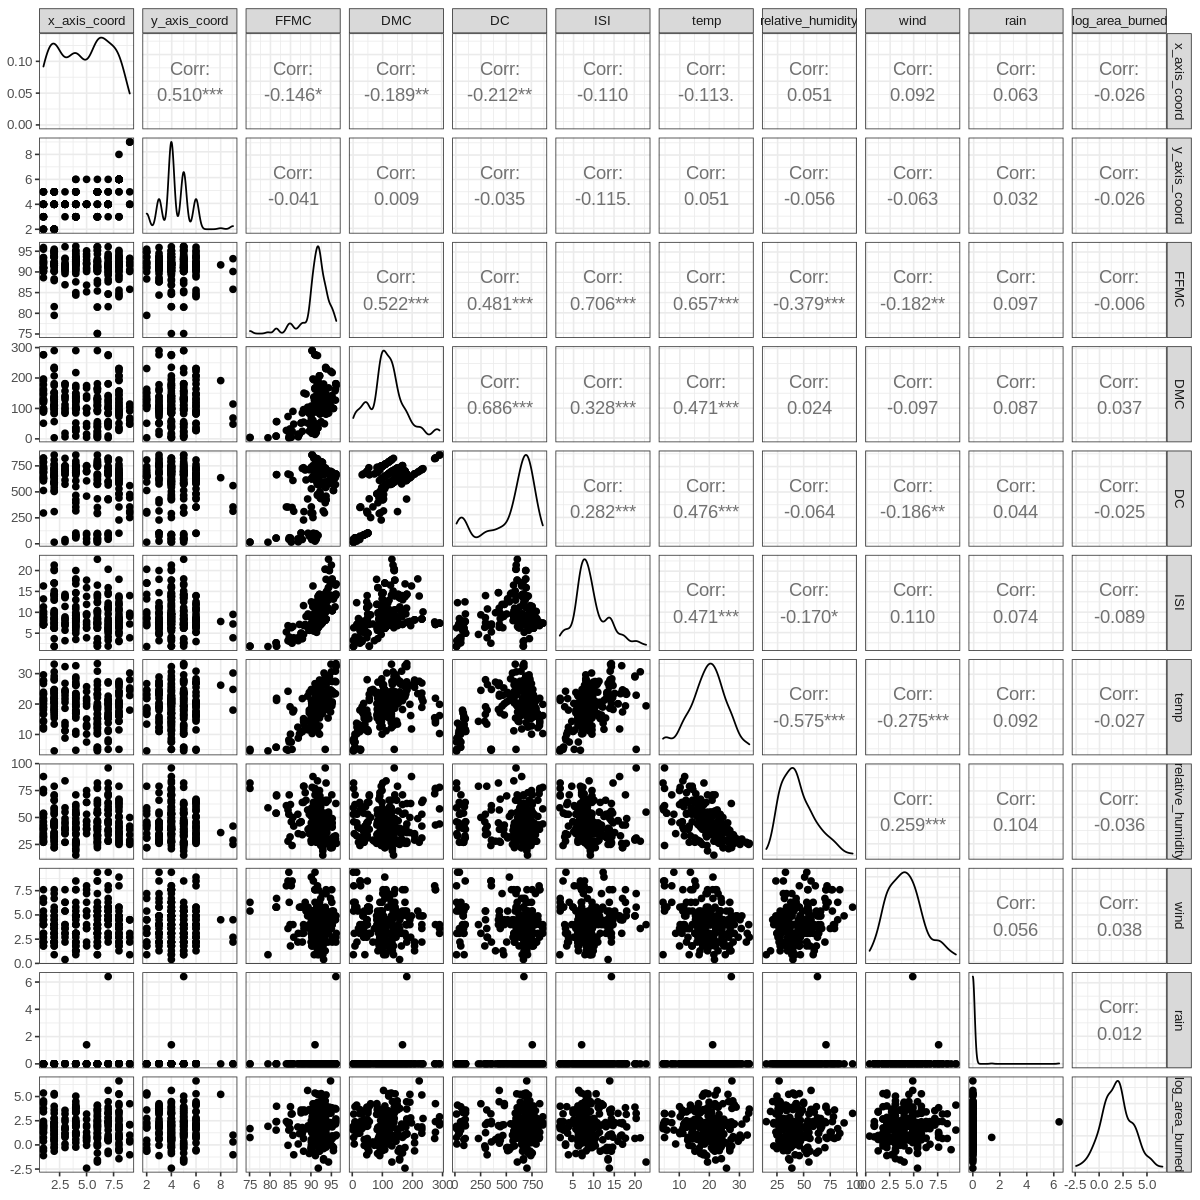

In [11]:
options(repr.plot.width = 10, repr.plot.height = 10) 

# GG pairs
forest_fire_numeric_data <- forest_train_clean_data %>%
    select(-month)
forest_fire_ggpairs <- ggpairs(forest_fire_numeric_data) +
    theme_bw(base_size = 10)
forest_fire_ggpairs

| _Figure 3: GGpairs Plot of All Numeric Variables in Clean Training Forest Fire Dataset_|
| ------------------------ |
||

Looking at Figure 3, there is a wide range of relationships between the different variables. For example, the variables `wind` and `temp` don't appear to have a strong correlation, as the scatterplot for the two looks to be a general cloud of data points. On the other hand, we can see stronger relationships in other pairs of variables, such as `DC` and `DMC`, which clearly show some positive correlation. 

Looking at the column in this figure for `log_area_burned`, we see that `ISI` has the highest magnitude of correlation (-0.089). 

From this figure we can conclude there is a wide range of relationships between variables, so to further explore this we will create a heat map. 


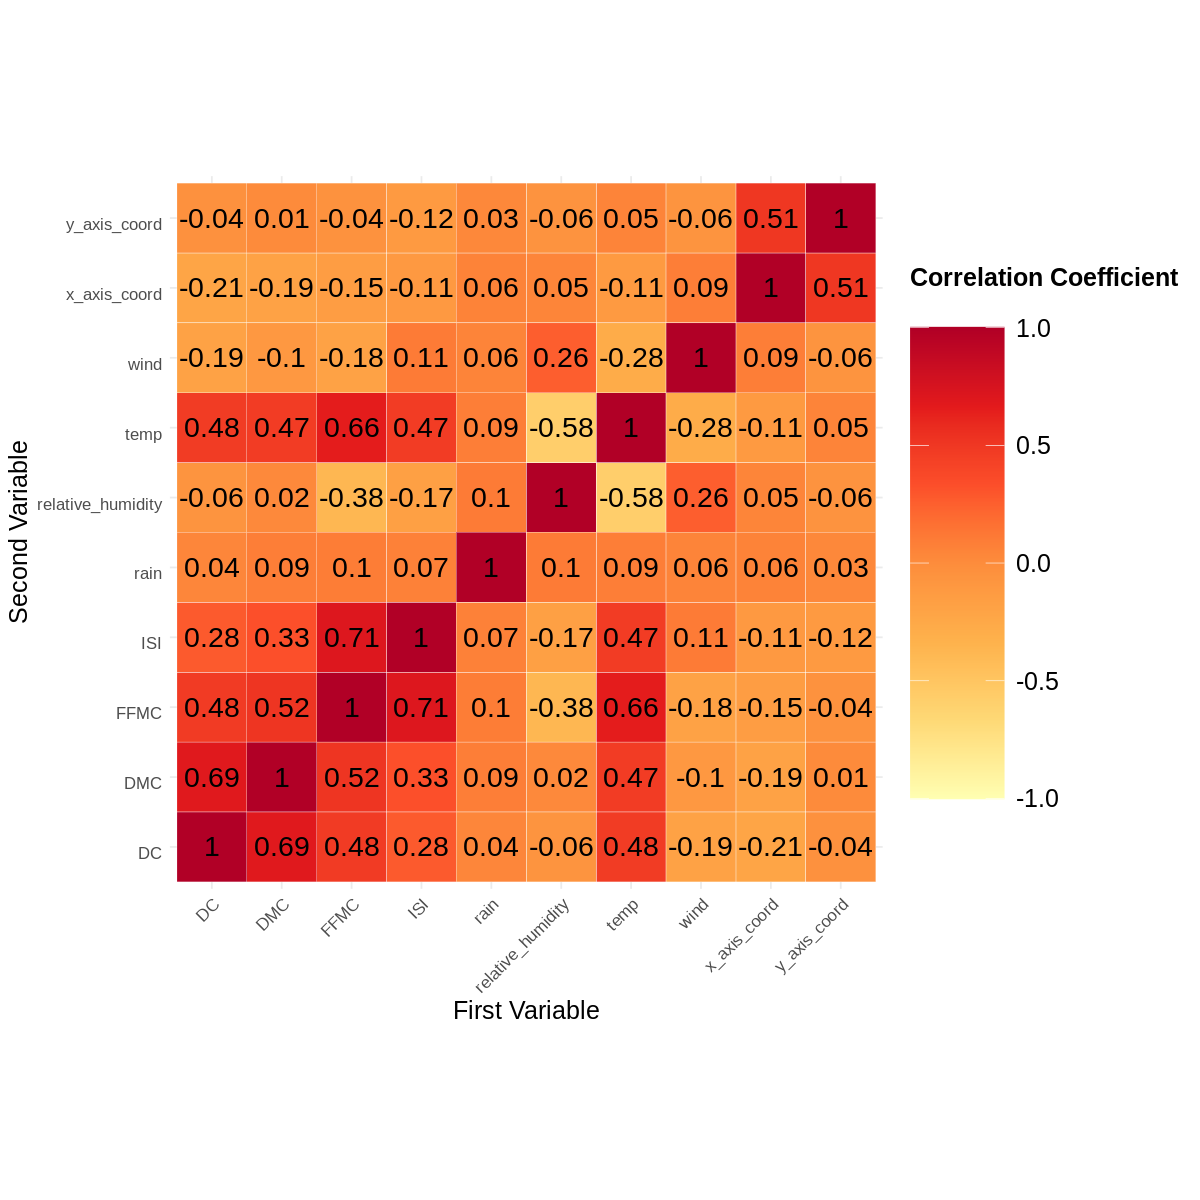

In [12]:
options(repr.plot.width = 10, repr.plot.height = 10) 

# Heat Map 

#First, find correlation matrix for all potential explanatory variables
corr_matrix_forest_fire <- forest_fire_numeric_data %>%
  select(-log_area_burned) %>% 
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")

#Create the Heat Map based on the correlation matrix found 
plot_corr_matrix_forest_fires <- corr_matrix_forest_fire %>%
  ggplot(aes(x = var1, y = var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
    palette =  "YlOrRd", direction = 1, limits = c(-1, 1)) +
  labs(x = "First Variable", y = "Second Variable") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 10, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 10, hjust = 1
    ),
    axis.title = element_text(size = 15),
    legend.title = element_text(size = 15, face = "bold"),
    legend.text = element_text(size = 15),
    legend.key.size = unit(2, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(x = var1, y = var2, label = round(corr, 2)), color = "black", size = 6)
plot_corr_matrix_forest_fires

| _Figure 4: Heat Map of All Numeric Variable Correlations_|
| ------------------------ |
||

Based on the heat map, we can see that the most correlated variables are `DMC` & `DC` (0.69), `FFMC` and `temp` are correlated at 0.66, and all other correlations are below 0.55. This suggests that we will need eliminate either `DMC` or `DC`, and perhaps `FFMC` or `temp` in order to ensure our results are not impacted by colinearity.

To conclude our exploratory analysis, we will take a look at a couple of summary statistics for all of our numeric variables. Specifically, we will look at their mean, standard deviation, min, and max. In order to format the above information properly, we have created a markdown cell below.

In [13]:
# Get list of means of each variable
var_means <- apply(forest_fire_numeric_data,2,mean)

# Get list of standard deviations of each variable
var_sd <- apply(forest_fire_numeric_data,2,sd)

# Get list of minimums of each variable
var_min <- apply(forest_fire_numeric_data,2,min)

# Get list of maximums of each variable
var_max <- apply(forest_fire_numeric_data,2,max)

| Summary Statistic        |   x_axis_coord   |   y_axis_coord    | FFMC |DMC    | DC | ISI    | temp | relative_humidity    | wind |  rain   | log_area_burned |
| -------- | --------- | --------- | --------- |  --------- | --------- | --------- | --------- | --------- | --------- | --------- | --------- |
| Mean     |  4.65| 4.27 | 90.72 |  113.95 | 556.71 | 9.10 | 19.08 | 43.87 | 3.99 | 0.01 | 13.9 |
| Standard Deviation   | 2.35 | 1.23| 5.55|  64.39 | 244.99 | 4.64 | 5.80 | 16.57 | 1.79 | 0.10 | 69.5 |
| Minimum Value   | 1 | 2| 18.7|  1.1 | 7.9 | 0 | 4.2 | 15 | 0.4 | 0 | 0 |
| Maximum Value   | 9 | 9| 96.2|  291.3 | 860.6 | 56.1 | 33.3 | 100 | 9.4 | 1.4 | 1090.84 |


| _Table 4: Summary Statistics For All Numeric Variables_|
| ------------------------ |
||

From Table 4, we can see that our numeric variables have a wide variety of means, standard deviations and ranges. As such, they will need to be scaled in the future in order to ensure that no one variable is deemed "more important" than any other simply due to its range.

Doing this will help us to eliminate any bias, and ensure accurate results in our report!
From this exploratory analysis, we can conclude that all the remaining variables are worth further investigation in our project as explanatory variables to log area burned.


## Results

For clarity, here is a brief overview of the steps taken in this section:

- Calculate the Test RMSE of the full model
- Check for multicollinearity among our input variables
- With our training data, apply forward selection and use the Cp statistic to choose predictor variables
- With our training data, create a linear regression model which will predict "log area burned", our response variable
- Check for issues such as heteroscedasticity and normality in our model
- With our test data, evaluate the statistical model using the Test Root Mean Squared Error
- Make a prediction using local forest data from British Columbia, while keeping in mind issues around generalizability

Before making a full model prediction, we first identify that there are no data points corresponding to the month of november. As such, we cannot make predictions for november because it does not exist in our training data

In [14]:
# Filtering out month of november
forest_test_clean_data <- forest_test_clean_data %>%
filter(month != "nov")

### Full model prediction

Starting off, we will a create a full model using multiple linear regression with `log_area_burned` as our response variable and all other variables as our explanatory variables.

In [15]:
# Use the method lm to create an additive multiple linear regression model
burned_full_model <- lm(log_area_burned ~ .,
                        data = forest_train_clean_data)
# head(tidy(burned_full_model))

Using our full LS model, we predict the value of log_area_burned on our unseen testing data and show the first 6 values that were predicted.

In [16]:
# Predict the value of our response variable on our testing data using the predict function
burned_full_model_predictions <- predict(burned_full_model, newdata = forest_test_clean_data)
head(burned_full_model_predictions)

1         2         3         4         5         6 
2.4235733 2.3587101 1.7631851 1.2517111 0.6045856 2.7634204

Using our predictions, we calculate the Test RMSE (Root Mean Squared Error) for the full LS model. 

In [17]:
# Using the rmse function, find the test rmse of our full LS model
burned_R_MSE_models <- tibble(
  Model = "OLS Full Regression",
  R_MSE = rmse(
    predicted = burned_full_model_predictions,
    actual = forest_test_clean_data$log_area_burned
  )
)
burned_R_MSE_models

Model,R_MSE
<chr>,<dbl>
OLS Full Regression,1.425019


_**Table 5: RMSE for Full Model**_

The RMSE is a measurement of how well new responses from our test set are estimated by the predicted values calculated by our model, with better models having lower RMSE values. As shown in table 5, the value of our full model's RMSE is about 1.425. However, without having other values to compare against, it is hard to determine at this point whether this RMSE value is considered "good".

### Checking for Multicollinearity

Next, it is important to check the multicollinearity of the model. If there are explanatory variables in our model that are highly correlated, then this would result in very unstable coefficients, as well as the least squares estimators of the regression coefficients having inflated standard error estimates. It would also be hard to determine how the collinear variables are separately associated with the response. If multicollinearity is found, then for each pair of collinear variables, one variable should be eliminated from our model. We will do this by looking at the $GVIF^{\frac{1}{2*Df}}$. This is due to the fact that the base GVIF value is inflated because month has many degrees of freedom due to having many dummy variables.

In [18]:
# Train full model
full_train_model <- lm(log_area_burned ~ .,
                        data = forest_train_clean_data)

In [19]:
# Find GVIF and GVIF^(1/(2*Df)) for each explanatory variable
VIF_MLR_CASchools <- car::vif(burned_full_model) %>%
round(3)
VIF_MLR_CASchools

,GVIF,Df,GVIF^(1/(2*Df))
x_axis_coord,1.635,1,1.279
y_axis_coord,1.573,1,1.254
month,128.432,9,1.310
FFMC,4.372,1,2.091
DMC,3.477,1,1.865
DC,30.493,1,5.522
ISI,2.901,1,1.703
temp,4.846,1,2.201
relative_humidity,2.786,1,1.669
wind,1.390,1,1.179


_**Table 6: VIF Values for All Input Variables**_

Looking just at the GVIF in Table 6, we see that `month` has a very high GVIF because of its high DF. As expected, when using the $GVIF^{\frac{1}{2*Df}}$ value instead, the value drops from 128.432 to 1.310, suggesting that the month variable actually doesn't collinearity issues. 

The standard for $GVIF^{\frac{1}{2*Df}}$ is to drop variables with values higher than 2. From Table 6, we see that DC, temp, and FFMC have the only values greater than 2 at 5.522, 2.201, and 2.091 respectively. For this reason, we will drop DC, as it has the highest $GVIF^{\frac{1}{2*Df}}$ value by far. From our heat map (Figure 4), we know that temp and FFMC are highly correlated. Therefore, of the two variables, we will drop the one with the higher value which is temp. 

In [20]:
# Dropping the variables DC and temp as they were potentially causing collinearity issues
forest_train_clean_data_vif <- forest_train_clean_data %>%
select(-c(temp, DC))

### Predictor Variable Selection

While we did find the RMSE for our full model, it is possible that not all the variables we used were relevant. Therefore, we will use forward selection in order to determine which variables should even be used in our model.

In [21]:
# Use forward selection 
burned_forward_sel <- regsubsets(
  x= log_area_burned ~ ., 
  nvmax= 17,
  data=forest_train_clean_data_vif,
  method="forward",
)

burned_reduced_summary <- summary(burned_forward_sel)

fat_bwd_summary_df <- data.frame(
   n_input_variables = 1:17,
   RSS = burned_reduced_summary$rss,
   BIC = burned_reduced_summary$bic,
   Cp = burned_reduced_summary$cp
)

fat_bwd_summary_df
summary(burned_forward_sel)

n_input_variables,RSS,BIC,Cp
<int>,<dbl>,<dbl>,<dbl>
1,500.2354,5.512061,-1.663722
2,493.0631,7.767961,-2.679479
3,489.4533,11.556070,-2.197288
4,485.2262,15.057768,-1.974697
5,479.3635,17.807341,-2.439824
6,477.2236,22.216224,-1.339601
7,475.9852,27.030257,0.139688
8,474.5878,31.770481,1.552128
9,473.7027,36.742564,3.179983


Subset selection object
Call: regsubsets.formula(x = log_area_burned ~ ., nvmax = 17, data = forest_train_clean_data_vif, 
    method = "forward", )
17 Variables  (and intercept)
                  Forced in Forced out
x_axis_coord          FALSE      FALSE
y_axis_coord          FALSE      FALSE
monthaug              FALSE      FALSE
monthdec              FALSE      FALSE
monthfeb              FALSE      FALSE
monthjul              FALSE      FALSE
monthjun              FALSE      FALSE
monthmar              FALSE      FALSE
monthmay              FALSE      FALSE
monthoct              FALSE      FALSE
monthsep              FALSE      FALSE
FFMC                  FALSE      FALSE
DMC                   FALSE      FALSE
ISI                   FALSE      FALSE
relative_humidity     FALSE      FALSE
wind                  FALSE      FALSE
rain                  FALSE      FALSE
1 subsets of each size up to 17
Selection Algorithm: forward
          x_axis_coord y_axis_coord monthaug monthdec mont

_**Table 7: Selection Values for Input Variables**_

Since we are building a predictive model, we will use Cp as our evaluation metric. Based on Table 7, we see that the best value for Cp (lowest value) occurs when there are two variables: `monthAug` and `DMC`. `DMC` is the same variable as in our original clean dataset while `monthAug` is a dummy variable which tells us whether it is or isn't August. 

Since `monthAug` has been found to be one of two relevant variables, we create a new column specifically giving us this information.

In [22]:
train_data_aug = forest_train_clean_data_vif %>%
mutate(aug = ifelse(month == "aug", "Yes", "No"))

test_data_aug = forest_test_clean_data %>%
mutate(aug = ifelse(month == "aug", "Yes", "No"))

### Create Reduced LR Model

Based on the results from our variable selection, we create a reduced linear regression model with our two relevant variables and predict on our training set. 

In [23]:
# Creating reduced linear regression model with 2 explanatory variables using lm function.
burned_red_model <- lm(log_area_burned ~ aug + DMC,
                     data = train_data_aug)

In [24]:
burned_red_train_predictions <- predict(burned_red_model, newdata = train_data_aug)

### Checking Heteroscedasticity and Normality

Having independent and identically distributed errors is another important assumption that is important for least squares models. Otherwise, when errors don't have equal variance and heteroscedasticity is present, model predictions are much less reliable because estimated standard errors are inflated. As such, we will check the distribution of our errors.

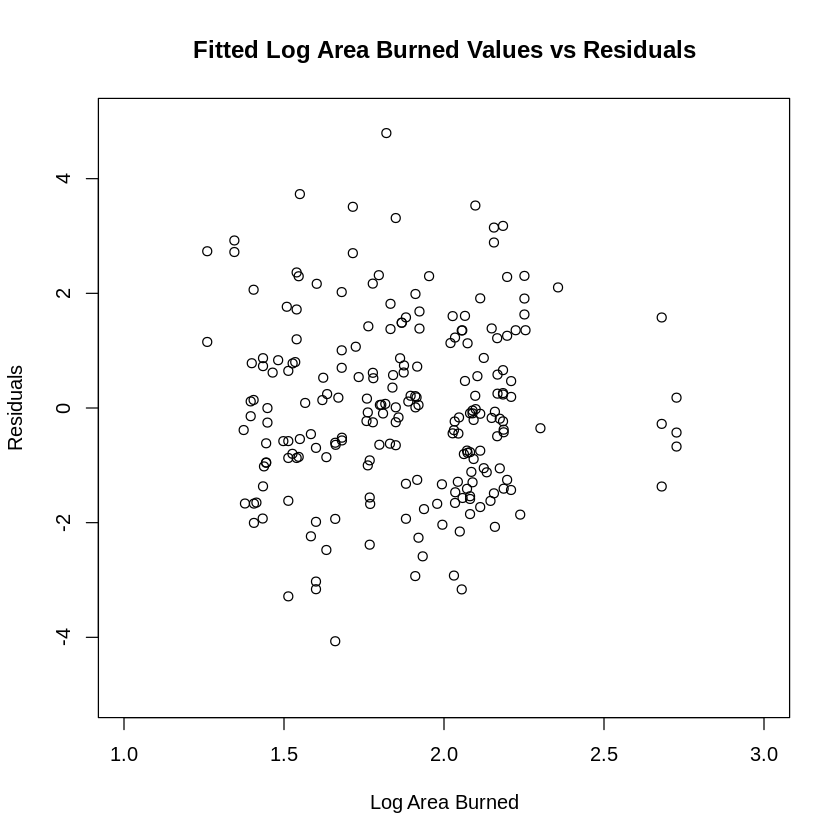

In [25]:
options(repr.plot.width = 7, repr.plot.height = 7) 

# Calculating residuals of reduced model
residuals = forest_train_clean_data$log_area_burned - burned_red_train_predictions
fit_values = burned_red_train_predictions

# Plotting graph of residuals to fitted values to discover whether heteroscedasticity is present
plot(x = fit_values, y = residuals, xlim = c(1,3), ylim = c(-5, 5), 
     main = "Fitted Log Area Burned Values vs Residuals", xlab = "Log Area Burned", ylab = "Residuals")

_**Figure 5: Checking for Heteroscedasticity using Fitted Values vs Residuals**_

Looking at figure 5 we notice an absence of any sort of pattern or "cone shape" for the points. Therefore, we can conclude that heteroscedasticity is not a problem. 

Moving onto a different assumption, it is also important to check that the conditional distribution of the errors is normal. When the conditional distribution of our errors is normal, then we know that the conditional expectation of our response variable is linear which establishes that a linear model is the right approach.

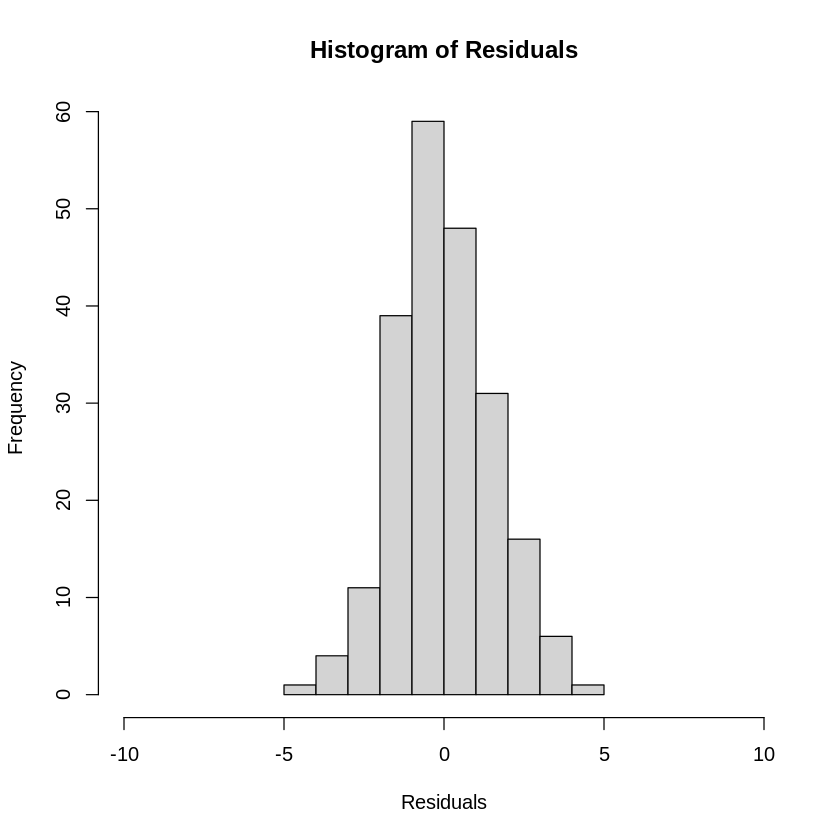

In [26]:
# Plotting histogram of the residuals

options(repr.plot.width = 7, repr.plot.height = 7) 
hist(residuals, xlab = "Residuals", main = "Histogram of Residuals", xlim = c(-10, 10))

_**Figure 6: Checking for Normality Using a Histogram of Residuals**_

Looking at figure 6, we see that the distribution of the residuals of our model is approximately normal. This is to be expected as we had done a log transformation previously on our response variable in order to make the distribution of our residuals more normal. 

Overall, both the lack of heteroscedasticity and the conditional normal distribution of the error have been established which lends a lot more credibility to our model.

### Evaluate Reduced Model with Test Data

Now that we have ensured that errors are independent and identically distributed, that the conditional distribution for error terms is normal, and that there are no multicollinearity issues, we have a lot of confidence in our model. Thus, we will use it to predict on our test data which it has not interacted with before.

In [27]:
# Predicting using testing data
burned_red_model_predictions <- predict(burned_red_model, newdata = test_data_aug)
head(burned_red_model_predictions)

1        2        3        4        5        6 
2.184446 2.174312 2.020274 1.919946 1.434422 2.238156

We will now assess the quality of the predictions of our reduced model in the same way that we assessed the quality of the predictions of our full model.

In [28]:
# Find RMSE of our reduced model
burned_R_MSE_models <- rbind( 
  burned_R_MSE_models,
  tibble(
  Model = "OLS Reduced Regression",
  R_MSE = rmse(
    predicted = burned_red_model_predictions,
    actual = forest_test_clean_data$log_area_burned)
  )
)
burned_R_MSE_models

Model,R_MSE
<chr>,<dbl>
OLS Full Regression,1.425019
OLS Reduced Regression,1.476015


 _**Table 8: Comparing RMSE for Full and Reduced Models**_

Even though our reduced model had a total of 2 variables as opposed to the 19 from our full model, it's RMSE is extremely close to our full model and is only 0.05 higher.

### Make Prediction

Now to make a prediction for Martin's Gulch, BC. Martin's Gulch is located on vancouver island and it's weather information is included here: https://www.crd.bc.ca/about/data/fire-weather-conditions. 

We can see that Martin's Gulch has a DMC value of 5.9. This value was last updated November 18, 2022, 12:00:00 PM.

What is DMC?

"The Duff Moisture Code (DMC) is a numeric rating of the average moisture content of loosely compacted organic layers of moderate depth. This code gives an indication of fuel consumption in moderate duff layers and medium-size woody material."

source: https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi?wbdisable=true

Now let's make a prediction.

In [29]:
BC_data <- tibble(aug = "No", DMC = 5.9)
BC_prediction <- predict(burned_red_model, BC_data, interval="prediction")
BC_prediction

,fit,lwr,upr
1,1.766922,-1.261259,4.795102


We predict that if a Forest fire were to occur in Martin's Gulch, BC right now it would cover $e^{1.767}$ (≈ 5.853) hectares. In addition, with 95% confidence the actual area burned is between $e^{-1.261}$ and $e^{4.795}$ (≈ 0.283 and 120.904) hectares.

## Discusion

## References

[1] Amorim, Jorge & J.J., KEIZER & A.I., MIRANDA & K., MONAGHAN. (2011). Forest fires research: beyond burnt area statistics. 

[2] Pitman, A. J., Narisma, G. T., & McAneney, J. (2007). The impact of climate change on the risk of forest and grassland fires in Australia. Climatic Change, 84(3-4), 383–401. https://doi.org/10.1007/s10584-007-9243-6 
